In [ ]:

import os
import sys

path = os.getcwd()
sys.path.insert(0, os.path.join(path, '..', 'src'))

import pandas as pd
import numpy as np
import data_preparation as dp

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv(r'..\data\raw\base_train.csv',sep='|', encoding='utf-8')
import data_preparation as dp


cleaner = dp.DataCleaner()
df = cleaner.clean(df)

# Feature selection

## rebalanceo de datos

In [ ]:
from sklearn.utils import resample

# Separar las clases
df_majority = df[df['default'] == 0]
df_minority = df[df['default'] == 1]

# Submuestreo de la clase mayoritaria a una proporción 3:1 respecto a la clase positiva
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=3 * len(df_minority),
    random_state=42
)

df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42)  

df_balanced['default'].value_counts()

default
0    5637
1    1879
Name: count, dtype: int64

## preprocesamiento

In [ ]:

# Separación de variables numéricas y categóricas
numerical_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['default']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocesamiento para numéricas: imputación + escalado
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocesamiento para categóricas: imputación + one-hot
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinación con ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

y = df['default']
X = df.drop(columns=['default'])

# Aplicar preprocesamiento
X_preprocessed = preprocessor.fit_transform(X)

ohe_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)
processed_columns = numerical_cols + ohe_columns.tolist()

X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=processed_columns)

In [6]:
X_preprocessed_df.columns

Index(['trx39', 'trx102', 'trx106', 'trx143', 'trx158', 'CO01END010RO',
       'CO01ACP017CC', 'CO02EXP011TO', 'CO02EXP004TO', 'CO01EXP001CC',
       'CO01EXP003RO', 'CO02END015CC', 'CO01END002RO', 'CO01END086RO',
       'CO01END094RO', 'CO02NUM086AH', 'CO02NUM043RO', 'CO01EXP002AH',
       'CO01END051RO', 'CO01ACP011RO', 'disp309_alto', 'disp309_bajo',
       'disp309_desconocido', 'disp309_medio', 'CO01NUM002AH_alto',
       'CO01NUM002AH_bajo', 'CO01NUM002AH_medio', 'CO01NUM002AH_sin_ahorro',
       'CO02MOR092TO_alto', 'CO02MOR092TO_bajo', 'CO02MOR092TO_desconocido',
       'CO02MOR092TO_medio', 'CO01MOR098RO_alto', 'CO01MOR098RO_bajo',
       'CO01MOR098RO_desconocido', 'CO01MOR098RO_medio'],
      dtype='object')

## eliminacion variables altamente correlacioandas

In [ ]:
X_numeric = X_preprocessed_df.select_dtypes(include=[np.number])

corr_matrix = X_numeric.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold_corr = 0.8
to_drop_corr = [column for column in upper.columns if any(upper[column] > threshold_corr)]

X_corr_filtered = X_numeric.drop(columns=to_drop_corr)

print(f"Variables eliminadas por correlación alta ({threshold_corr}):\n{to_drop_corr}")
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'correlation'})
)
corr_pairs['abs_correlation'] = corr_pairs['correlation'].abs()

corr_pairs[corr_pairs['abs_correlation'] > 0.8].sort_values(by='abs_correlation', ascending=False).head(10)


Variables eliminadas por correlación alta (0.8):
['trx158', 'CO01END094RO', 'CO01ACP011RO', 'CO01NUM002AH_medio', 'CO02MOR092TO_desconocido', 'CO01MOR098RO_desconocido']


,var1,var2,correlation,abs_correlation
575,CO01NUM002AH_bajo,CO01NUM002AH_medio,0.943479,0.943479
625,CO01MOR098RO_alto,CO01MOR098RO_desconocido,0.915062,0.915062
3,trx39,trx158,0.870329,0.870329
603,CO02MOR092TO_alto,CO02MOR092TO_desconocido,0.853169,0.853169
173,CO01END010RO,CO01END094RO,0.808476,0.808476
442,CO02NUM043RO,CO01ACP011RO,0.806814,0.806814


In [ ]:


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr_filtered)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_corr_filtered.columns)

threshold_vif = 10
vif_data = pd.DataFrame()
features = list(X_scaled_df.columns)

while True:
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X_scaled_df[features].values, i) for i in range(len(features))]

    max_vif = vif_data["VIF"].max()
    if max_vif > threshold_vif:
        drop_feat = vif_data.sort_values(by="VIF", ascending=False).iloc[0]["feature"]
        print(f"Eliminando por VIF alto: {drop_feat} (VIF={max_vif:.2f})")
        features.remove(drop_feat)
    else:
        break

X_vif_filtered = X_scaled_df[features]
if len(features) < X_corr_filtered.shape[1]:
    print(f"Variables eliminadas por VIF alto (> {threshold_vif}):\n{set(X_corr_filtered.columns) - set(features)}")
else:
    print("No se eliminaron variables por VIF alto.")

c:\Users\sojua\OneDrive\Desktop\prueba_ifrs9\env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\sojua\OneDrive\Desktop\prueba_ifrs9\env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\sojua\OneDrive\Desktop\prueba_ifrs9\env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\sojua\OneDrive\Desktop\prueba_ifrs9\env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Eliminando por VIF alto: disp309_medio (VIF=inf)
Variables eliminadas por VIF alto (> 10):
{'disp309_medio'}


Variables seleccionadas con Lasso:
['trx39', 'trx102', 'trx106', 'CO01END010RO', 'CO02EXP011TO', 'CO02EXP004TO', 'CO02END015CC', 'CO01END002RO', 'CO01END086RO', 'CO02NUM086AH', 'CO02NUM043RO', 'CO01EXP002AH', 'CO01END051RO', 'disp309_alto', 'disp309_bajo', 'disp309_desconocido', 'CO01NUM002AH_alto', 'CO01NUM002AH_bajo', 'CO02MOR092TO_alto', 'CO02MOR092TO_bajo', 'CO02MOR092TO_medio', 'CO01MOR098RO_bajo', 'CO01MOR098RO_medio']


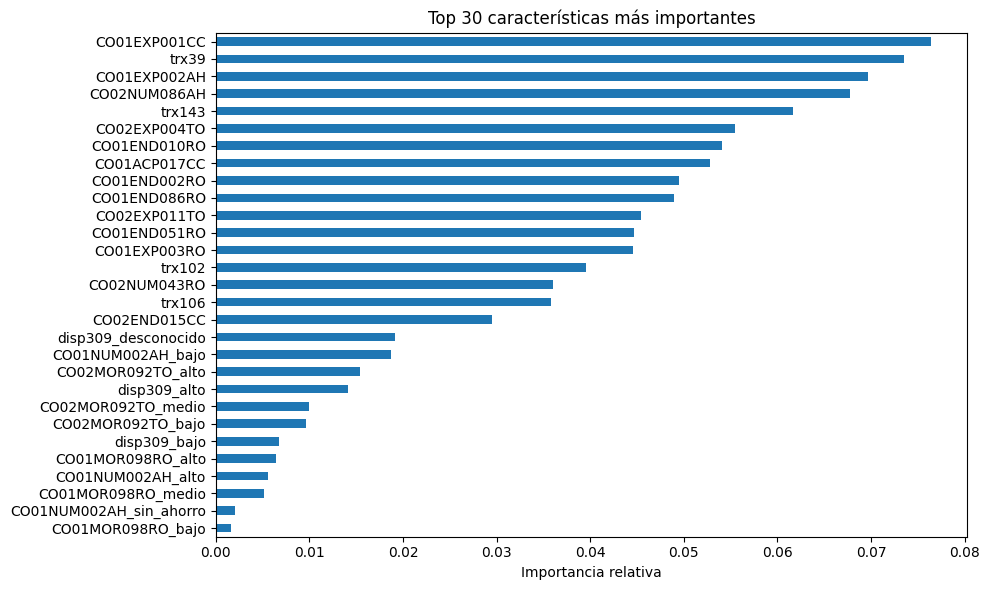

In [ ]:


y = df['default']

lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
lasso_model.fit(X_vif_filtered, y)

selector = SelectFromModel(lasso_model, prefit=True)
X_lasso_selected = X_vif_filtered.loc[:, selector.get_support()]

print(f"Variables seleccionadas con Lasso:\n{list(X_lasso_selected.columns)}")

X_train, X_test, y_train, y_test = train_test_split(X_vif_filtered, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X_vif_filtered.columns)
importances_sorted = importances.sort_values(ascending=False)

# Seleccionamos el top 30 más importante

top_features = importances_sorted.head(30)

# Gráfico
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title(f'Top {30} características más importantes')
plt.xlabel('Importancia relativa')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [10]:
# exportar características seleccionadas
selected_features = top_features.index.tolist()
output_path = r'..\data\processed\selected_features.csv'
selected_features_df = pd.DataFrame(selected_features, columns=['feature'])
selected_features_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"Características seleccionadas exportadas a {output_path}")

Características seleccionadas exportadas a ..\data\processed\selected_features.csv
